In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import glob
import tqdm


In [3]:
import PIL
import numpy as np
from PIL import Image
from numpy import asarray
# Open the image form working directory
num_train_samples=3000
from tqdm import tqdm

def getData(num_train_samples=1000,FILEPATHS=['../../datasets/med_MNIST/AbdomenCT/*jpeg',
                       '../../datasets/med_MNIST/HeadCT/*jpeg',
                       '../../datasets/med_MNIST/ChestCT/*jpeg']):
    FILES={}
    count=0
    for i in FILEPATHS:
        FILES[count]=glob.glob(i)
        count=count+1
        
    NUM_CLASSES=len(FILEPATHS)
    ar_tr = np.zeros([num_train_samples*NUM_CLASSES,64, 64, 3], dtype=np.uint8)
    label_tr=np.empty((num_train_samples*NUM_CLASSES,), dtype='uint8')
    ar_ts = np.zeros([num_train_samples*NUM_CLASSES,64, 64, 3], dtype=np.uint8)
    label_ts=np.empty((num_train_samples*NUM_CLASSES,), dtype='uint8')
    count=0
    for f in tqdm(FILES[0]):
        #print('XX',count)
        image = Image.open(f)
        if count <num_train_samples:
            data = asarray(image)
            ar_tr[count,:,:,1]=data
            ar_tr[count,:,:,2]=data
            ar_tr[count,:,:,0]=data
            label_tr[count]=0
        if count>=num_train_samples:
            data = asarray(image)
            ar_ts[count-num_train_samples,:,:,1]=data
            ar_ts[count-num_train_samples,:,:,2]=data
            ar_ts[count-num_train_samples,:,:,0]=data
            label_ts[count-num_train_samples]=0
        count=count+1
        if count==num_train_samples*2:
            break


    count=0
    for f in tqdm(FILES[1]):
        #print('XXX',count)
        image = Image.open(f)
        if count <num_train_samples:
            data = asarray(image)
            ar_tr[count+num_train_samples,:,:,1]=data
            ar_tr[count+num_train_samples,:,:,2]=data
            ar_tr[count+num_train_samples,:,:,0]=data
            label_tr[count+num_train_samples]=1
        if count>=num_train_samples:
            data = asarray(image)
            #print(count)
            ar_ts[count,:,:,1]=data
            ar_ts[count,:,:,2]=data
            ar_ts[count,:,:,0]=data
            label_ts[count]=1
        count=count+1
        if count==num_train_samples*2:
            break

    count=0
    for f in tqdm(FILES[2]):
        #print('XXX',count)
        image = Image.open(f)
        if count <num_train_samples:
            data = asarray(image)
            ar_tr[count+2*num_train_samples,:,:,1]=data
            ar_tr[count+2*num_train_samples,:,:,2]=data
            ar_tr[count+2*num_train_samples,:,:,0]=data
            label_tr[count+2*num_train_samples]=2
        if count>=num_train_samples:
            data = asarray(image)
            #print(count)
            ar_ts[count+num_train_samples,:,:,1]=data
            ar_ts[count+num_train_samples,:,:,2]=data
            ar_ts[count+num_train_samples,:,:,0]=data
            label_ts[count+num_train_samples]=2
        count=count+1
        if count==num_train_samples*2:
            break
            
            
    x_train=ar_tr
    x_test=ar_ts
    y_train=label_tr
    y_test=label_ts
    return (x_train, y_train), (x_test, y_test)

In [4]:
(train_images, train_labels), (test_images, test_labels)=getData(num_train_samples)

 22%|██▏       | 2217/10000 [00:16<00:26, 290.95it/s]


 60%|█████▉    | 5968/10000 [00:26<00:10, 403.12it/s]

In [5]:
print(train_images.shape,len(train_labels))
print(test_images.shape,len(test_labels))


(9000, 64, 64, 3) 9000
(9000, 64, 64, 3) 9000


In [6]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

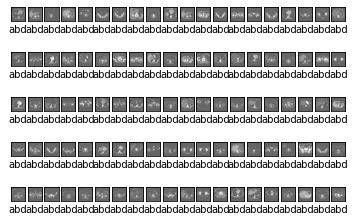

In [8]:
class_names = ['abd','bst','chst']

for i in range(100):
    plt.subplot(5,20,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])

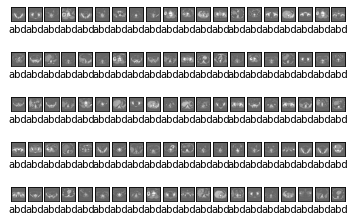

In [9]:
for i in range(100):
    plt.subplot(5,20,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[test_labels[i]])

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3,activation=tf.nn.softmax))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=3, 
                    validation_data=(test_images, test_labels))

Epoch 1/3
282/282 [==============================] - 16s 55ms/step - loss: 0.5957 - accuracy: 0.9554 - val_loss: 0.5531 - val_accuracy: 0.9991
Epoch 2/3
282/282 [==============================] - 13s 47ms/step - loss: 0.5617 - accuracy: 0.9900 - val_loss: 0.5575 - val_accuracy: 0.9934
Epoch 3/3
282/282 [==============================] - 13s 44ms/step - loss: 0.6928 - accuracy: 0.8586 - val_loss: 0.8848 - val_accuracy: 0.6667


282/282 - 2s - loss: 0.5536 - accuracy: 0.9977


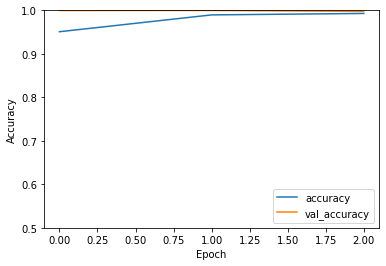

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [12]:
history.history

{'loss': [0.6016188263893127, 0.561855673789978, 0.5582709312438965],
 'accuracy': [0.9508888721466064, 0.9895555377006531, 0.992888867855072],
 'val_loss': [0.5522868633270264, 0.5518770813941956, 0.5535513162612915],
 'val_accuracy': [0.999666690826416, 0.9997777938842773, 0.9976666569709778]}